# Deep Learning Project: Cat Feature Identification with CNN

## 1. Main Objective

In this section, describe the main objective of your analysis. Specify that you will be using a Convolutional Neural Network (CNN), a type of Deep Learning algorithm, to identify key features on cat images, such as eyes, mouth, and ears. Explain the benefits that your analysis brings to the business or stakeholders of this data. For example, this could be used in applications like augmented reality filters for pets, automated tagging of pet photos, or veterinary diagnostics.

## 2. Data Description

### About the Dataset

**Context**

The CAT dataset includes over 9,000 cat images. For each image, there are annotations of the head of cat with nine points, two for eyes, one for mouth, and six for ears.

**Content**

The annotation data are stored in a file with the name of the corresponding image plus ."cat" at the end. There is one annotation file for each cat image. For each annotation file, the annotation data are stored in the following sequence:

Number of points (default is 9)
Left Eye
Right Eye
Mouth
Left Ear-1
Left Ear-2
Left Ear-3
Right Ear-1
Right Ear-2
-Right Ear-3

## 3. Data Exploration, Cleaning, and Feature Engineering

In [20]:
import kagglehub
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import tqdm
import seaborn as sns

sns.set_theme()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
dataset_totel = 1000 if torch.cuda.is_available() else 100
batch_size = 100 if torch.cuda.is_available() else 10
train_epochs = 40 if torch.cuda.is_available() else 2

In [22]:
class CatDataset(Dataset):
    def __init__(self, train=True):
        self.path = Path(kagglehub.dataset_download("crawford/cat-dataset"))/'cats'
        self.files = list(self.path.rglob("*.cat"))
        self.files.sort(key=lambda f: f.name)

        total = len(self.files) if dataset_totel == -1 else dataset_totel
        train_size = int(0.7*total)

        if train:
            self.files = self.files[0:train_size]
        else:
            self.files = self.files[train_size:total]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        if isinstance(index, slice):
            return [self[i] for i in range(*index.indices(len(self)))]

        file = self.files[index]

        # Parse keypoints
        with open(file, 'r') as f:
            points = list(map(int, f.read().strip().split(' ')))
            assert points[0] == 9
            points = np.array(points[1:])

        # Parse image
        image_file = file.parent / file.name[:-4]
        image = Image.open(image_file)
        original_size = image.size
        image_resized = np.array(image.resize((224, 224)))
        x_resized = torch.Tensor(image_resized) / 255
        x_resized = x_resized.view((3, 224, 224))

        # Scale keypoints
        points = points.reshape(-1, 2)
        points = (points * [1 / original_size[0], 1 / original_size[1]]).astype('float32')

        return x_resized.to(device=device), torch.Tensor(points.flatten()).to(device=device)

train_dataset = CatDataset(train=True)
test_dataset = CatDataset(train=False)

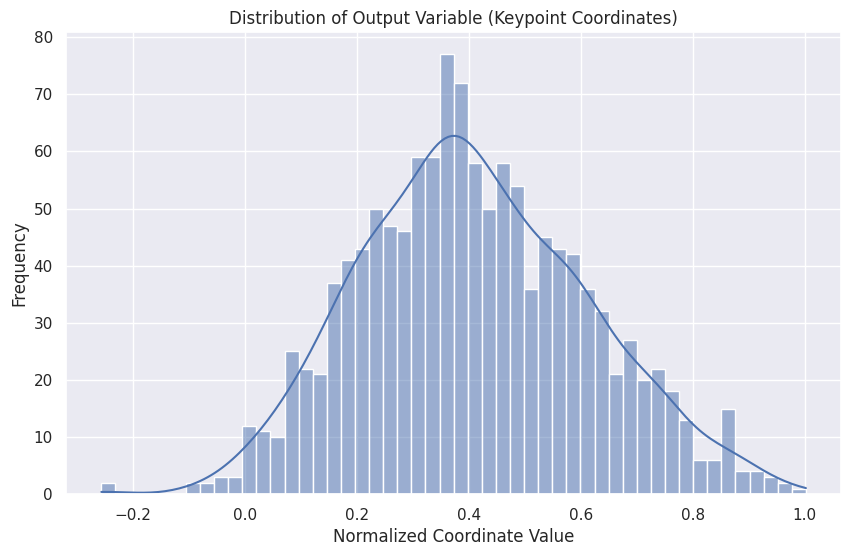

In [23]:
all_keypoints = []
for _, y in train_dataset:
    all_keypoints.append(y.cpu().numpy())

all_keypoints = np.concatenate(all_keypoints)

plt.figure(figsize=(10, 6))
sns.histplot(all_keypoints, bins=50, kde=True)
plt.title('Distribution of Output Variable (Keypoint Coordinates)')
plt.xlabel('Normalized Coordinate Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def display(data, model=None, title=None):
    n = len(data)
    if n == 0:
        print("No data to display.")
        return

    # When n=1, subplots returns a single Axes object, not an array.
    # We wrap it in a list for consistent indexing.
    fig, axes = plt.subplots(1, n, figsize=(n * 4, 5))
    if n == 1:
        axes = [axes]

    if title:
        fig.suptitle(title, fontsize=16)

    for i, (x, y) in enumerate(data):
        ax = axes[i]

        # Convert tensor from (C, H, W) to (H, W, C) for plotting
        image = x.view(224, 224, 3).cpu().numpy()
        ax.imshow(image)

        # Plot ground truth keypoints
        true_points = y.view(-1, 2).cpu().numpy() * 224
        ax.scatter(true_points[:, 0], true_points[:, 1], c='red', s=40, label='Ground Truth', marker='x')

        ax.axis('off')

        if model:
            model.eval()
            with torch.no_grad():
                # Model expects a batch, so we add a dimension, and it should already be on the correct device
                pred_y = model(x.unsqueeze(0))

            # Plot predicted keypoints
            pred_points = pred_y.view(-1, 2).cpu().numpy() * 224
            ax.scatter(pred_points[:, 0], pred_points[:, 1], c='yellow', s=40, label='Prediction', marker='x')

            # Calculate and display loss
            loss = loss_fn(pred_y, y.unsqueeze(0)).item()
            ax.set_title(f'Loss: {loss:.4f}')
        else:
            ax.set_title(f'Sample {i+1}')

    # Create a single legend for the figure
    if model and n > 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

In [ ]:
display(train_dataset[-10:], title='Train - Samples')
display(test_dataset[-10:], title='Test - Samples')

In [ ]:
# Data Cleaning and Preprocessing
# - Handle any missing data if necessary.
# - Normalize image pixel values (e.g., scale to [0, 1]).
# - Normalize keypoint coordinates.
# - Resize images to a consistent size for the CNN.

In [ ]:
training_loader = DataLoader(CatDataset(train=True), batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(CatDataset(train=False), batch_size=batch_size, shuffle=False)

## 4. Model Training

Here you will train at least three variations of your CNN model. For each variation, you should document the architecture, hyperparameters, and training process.

In [ ]:
loss_fn = nn.MSELoss()



def train(
    model,
    optimizer,
    epochs=10
):
    history = {
        'train': [],
        'test': []
    }

    for epoch in range(epochs):
        tq = tqdm.tqdm(enumerate(training_loader), f"Epoch {epoch+1}")

        running_loss = 0

        model.train(True)
        for i, (X_train, y_train) in tq:
            optimizer.zero_grad()

            y_pred = model.forward(X_train)

            loss = loss_fn(y_pred, y_train)
            loss.backward()

            running_loss += loss.item()

            optimizer.step()

        history['train'].append(running_loss/len(testing_loader))

        running_loss = 0

        model.eval()
        with torch.no_grad():
            for X_test, y_test in testing_loader:
                y_pred = model(X_test)
                loss = loss_fn(y_pred, y_test)
                running_loss += loss.item()

        history['test'].append(running_loss/len(testing_loader))

    return history

def plot_history(history, title='Model Training History'):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Combine histories if passed as a list
    if isinstance(history, list):
        train_losses = [item for sublist in history for item in sublist['train']]
        test_losses = [item for sublist in history for item in sublist['test']]
    else:
        train_losses = history['train']
        test_losses = history['test']

    epochs = range(1, len(train_losses) + 1)

    ax.plot(epochs, train_losses, 'o-', label='Training Loss')
    ax.plot(epochs, test_losses, 'o-', label='Validation Loss')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss (log scale)', fontsize=12)
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

    plt.show()

### Model Variation 1: Baseline CNN

In [ ]:


class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.sequential = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.MaxPool2d(4),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.MaxPool2d(4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5408, 100),
            nn.ReLU(),
            nn.Linear(100, 18),
        )

    def forward(self, X):
        return self.sequential(X)
baseline_model = BaselineCNN().to(device=device)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters())
baseline_history = []

In [ ]:
baseline_history.append(train(
    baseline_model,
    optimizer = baseline_optimizer,
    epochs=250
))

In [ ]:
plot_history(baseline_history, title='Baseline CNN Training History')

In [ ]:
display(train_dataset[-10:], model=baseline_model, title='Train - Baseline CNN Predictions')
display(test_dataset[-10:], model=baseline_model, title='Test - Baseline CNN Predictions')

### Model Variation 2: Deeper CNN

For this variation, you could try making the model deeper by adding more convolutional layers or using a more complex architecture.

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the convolutional layers
        # Input image: 3 channels (RGB), 224x224
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Output: 32x224x224
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # Output: 32x224x224
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2), # Output: 32x112x112
            nn.Dropout2d(0.2), # Dropout after pooling

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64x112x112
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Output: 64x112x112
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # Output: 64x56x56
            nn.Dropout2d(0.2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output: 128x56x56
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # Output: 128x56x56
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # Output: 128x28x28
            nn.Dropout2d(0.2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Output: 256x28x28
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Output: 256x28x28
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2), # Output: 256x14x14
            nn.Dropout2d(0.2),

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Output: 512x14x14
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Output: 512x14x14
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2), # Output: 512x7x7
            nn.Dropout2d(0.2)
        )

        # Calculate the flattened size after all convolutional and pooling layers
        # For a 224x224 input with 5 MaxPool2d(2) layers, the spatial dimension
        # becomes 224 / (2^5) = 224 / 32 = 7.
        # The last convolutional layer has 512 channels.
        self.flattened_size = 512 * 7 * 7 # 25088

        # Define the fully connected layers (classifier/head)
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flatten the 3D tensor into a 1D vector
            nn.Linear(self.flattened_size, 1024), # First fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5), # Regular dropout for fully connected layers
            nn.Linear(1024, 512), # Second fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 18) # Output layer with 18 neurons
        )

    def forward(self, X):
        X = self.features(X)
        X = self.classifier(X)
        return X
deeper_model = DeeperCNN().to(device=device)
deeper_optimizer = torch.optim.Adam(deeper_model.parameters())
deeper_history = []

In [ ]:
deeper_history.append(train(
    deeper_model,
    optimizer = deeper_optimizer,
    epochs=120
))

In [ ]:
plot_history(deeper_history, title='Deeper CNN Training History')

In [ ]:
display(train_dataset[-10:], model=deeper_model, title='Train - Deeper CNN Predictions')
display(test_dataset[-10:], model=deeper_model, title='Test - Deeper CNN Predictions')

### Model Variation 3: CNN with Autoencoders

First we train a autoencoder so we can use the encoder portion to represent the data in lower dimension to train the regressor on

In [ ]:
import torch
import torch.nn as nn

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim=1000):
        super(Encoder, self).__init__()
        # Input image: 3 channels (RGB), 224x224
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1) # Output: 64x112x112
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # Output: 128x56x56
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) # Output: 256x28x28
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1) # Output: 512x14x14
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1) # Output: 1024x7x7
        self.relu5 = nn.ReLU()

        # Calculate the flattened size after convolutional layers
        # For 224x224 input with stride 2 and padding 1 for 5 layers:
        # 224 -> 112 -> 56 -> 28 -> 14 -> 7
        # The number of channels for the last conv layer is 1024
        self.flattened_size = 1024 * 7 * 7 # 50176

        # Linear layer to project to the latent dimension
        self.fc = nn.Linear(self.flattened_size, latent_dim)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.relu5(self.conv5(x))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1) # Flatten while keeping batch size
        x = self.fc(x)
        return x

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim=1000):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.initial_channels = 1024
        self.initial_dim = 7 # Corresponds to 7x7 spatial dimension before transpose convs

        # Linear layer to project from latent dimension back to the flattened convolutional output size
        self.fc = nn.Linear(latent_dim, self.initial_channels * self.initial_dim * self.initial_dim)
        self.relu_fc = nn.ReLU()

        # Transpose convolutional layers to upsample the image
        # Input: 1024x7x7
        self.deconv1 = nn.ConvTranspose2d(self.initial_channels, 512, kernel_size=4, stride=2, padding=1) # Output: 512x14x14
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1) # Output: 256x28x28
        self.relu2 = nn.ReLU()
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) # Output: 128x56x56
        self.relu3 = nn.ReLU()
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # Output: 64x112x112
        self.relu4 = nn.ReLU()
        self.deconv5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1) # Output: 3x224x224

        # Sigmoid activation to ensure pixel values are between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu_fc(self.fc(x))

        # Reshape the output from the linear layer into a 3D tensor for transpose convolutions
        x = x.view(x.size(0), self.initial_channels, self.initial_dim, self.initial_dim)

        x = self.relu1(self.deconv1(x))
        x = self.relu2(self.deconv2(x))
        x = self.relu3(self.deconv3(x))
        x = self.relu4(self.deconv4(x))
        x = self.sigmoid(self.deconv5(x)) # Sigmoid for final image output (0-1 range)
        return x

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=1000):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder().to(device=device)
autoencoder_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-8)
autoencoder_history = []

In [ ]:
def train_autoencoder(
    model,
    optimizer,
    epochs=10
):


    history = {
        'train': [],
        'test': []
    }

    for epoch in range(epochs):
        tq = tqdm.tqdm(enumerate(training_loader), f"Epoch {epoch+1}")

        running_loss = 0

        model.train(True)
        for i, (X_train, _) in tq:
            optimizer.zero_grad()

            y_pred = model.forward(X_train)

            loss = loss_fn(y_pred, X_train)
            loss.backward()

            running_loss += loss.item()

            optimizer.step()

        history['train'].append(running_loss/len(testing_loader))

        running_loss = 0

        model.eval()
        with torch.no_grad():
            for X_test, _ in testing_loader:
                y_pred = model(X_test)
                loss = loss_fn(y_pred, X_test)
                running_loss += loss.item()

        history['test'].append(running_loss/len(testing_loader))

    return history

In [ ]:
autoencoder_history.append(
    train_autoencoder(
        autoencoder,
        optimizer=autoencoder_optimizer,
        epochs=train_epochs
    )
)

In [ ]:
plot_history(autoencoder_history, title='Autoencoder Training History')

In [ ]:
class AutoencoderCNN(nn.Module):
    def __init__(self, autoencoder: Autoencoder):
        super().__init__()

        for param in autoencoder.encoder.parameters():
            param.requires_grad = False

        self.sequential = nn.Sequential(
            autoencoder.encoder,
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 18),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.sequential(x)

autoencoder_model = AutoencoderCNN(autoencoder).to(device=device)
autoencoder_model_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=1e-4)
autoencoder_model_history = []

In [ ]:
autoencoder_model_history.append(
    train(
        autoencoder_model,
        optimizer=autoencoder_model_optimizer,
        epochs=train_epochs
    ))

In [ ]:
plot_history(autoencoder_model_history, title='Autoencoder CNN Training History')

In [ ]:
display(train_dataset[-10:], model=autoencoder_model, title='Train - Autoencoder CNN Predictions')
display(test_dataset[-10:], model=autoencoder_model, title='Test - Autoencoder CNN Predictions')

## 5. Final Model Selection

In this section, compare the performance of the three model variations. Explain which model you recommend as the final model and why. Consider factors like accuracy, computational cost, and explainability.

## 6. Key Findings and Insights

Summarize the key findings from your modeling exercise. What did you learn about the data and the effectiveness of CNNs for this task? Were there any surprising results? Visualize some of the best and worst predictions from your final model to illustrate its performance.

## 7. Next Steps and Future Work

Suggest potential next steps for this project. This could include:
- Collecting more data or more diverse data.
- Trying different model architectures (e.g., transfer learning with a pre-trained model like VGG16 or ResNet).
- Exploring different hyperparameter tuning techniques.
- Discuss any potential flaws or limitations of your current model.